# Drug data Target() Prediction

## 데이터 호출

In [95]:
import pandas as pd

In [96]:
drug_data = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2/drugsComTrain_raw.csv')

In [97]:
drug_data = drug_data.dropna()
drug_data.isna().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

## 전처리

### 전처리 함수

#### 숫자와 영어 알파벳을 제외한 문자를 공백으로 대체

In [98]:
import re

def extract_word(text):
    non_english = re.compile('[^a-zA-Z0-9]')
    return non_english.sub(' ', text)

#### 소문자로 변환

In [99]:
def fix_lower(text):
    fixed_text = text.lower() # 소문자로 변환
    return fixed_text

#### 불용어 제거

In [100]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt') #token
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/kdt-admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kdt-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [101]:
english_stopwords = set(stopwords.words('english'))
english_stopwords.discard('no') # no를 불용어에 포함시키지 않음
english_stopwords.discard('not') # not를 불용어에 포함시키지 않음

def del_stopwords(tokens):
    return [token for token in tokens if token not in english_stopwords and token.isalnum()]

#### 숫자와 수치형 단위 제거

In [102]:
def del_numericalunits(text):
    non_numericalunits = r'\b\d+(\.\d+)?\s?\S*' # 숫자와 단위 정규 표현식
    return re.sub(non_numericalunits, '', text)

#### Lemmatization


In [103]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def fix_lemmatization(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

[nltk_data] Downloading package wordnet to /home/kdt-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kdt-admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### 토큰화

In [104]:
from nltk.tokenize import word_tokenize

def fix_tokenize(text):
    return word_tokenize(text)

#### 공백 수정 및 토큰 연결

In [105]:
def join_tokens(tokens):
    return ' '.join(tokens) # 공백으로 연결

#### 공백 제거

In [106]:
def del_space(text):
    return text.replace(" ", "")

#### html 코드 제거

In [107]:
# from bs4 import BeautifulSoup

def del_html(text):
    # return BeautifulSoup(text, 'html.parser').get_text() # </span>만 제거되고 문장은 제거되지 않음.
    if '</span> users found this comment helpful.' in text:
        return ''
    else:
        return text

#### apostrophe 제거

In [108]:
def remove_apostrophe(text):
    return text.replace("'", "")

#### Stemming

In [109]:
from nltk.stem import PorterStemmer, LancasterStemmer

porter_stemmer = PorterStemmer()

lancaster_stemmer = LancasterStemmer()

##### Porter Stemming 

In [110]:
def porter_stemming(review):
    return [porter_stemmer.stem(word) for word in review]

##### Lancaster stemming

In [111]:
def lancaster_stemming(review):
    return [lancaster_stemmer.stem(word) for word in review]

#### Padding

In [112]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

##### Padding 적용 함수

In [113]:
def convert_padding(df, column_name):
    tokenizer.fit_on_texts(df[column_name])
    sequences = tokenizer.texts_to_sequences(df[column_name])
    max_length = max(len(sentence) for sentence in df[column_name]) # 최대 문장 길이
    padded_review = pad_sequences(sequences, maxlen=max_length, padding='post') # Padding
    
    return padded_review.tolist()

#### Embedding

In [114]:
import numpy as np

embedding_index = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [115]:
#def convert_embedding(df, column_name):
#    embedded_sequences = []
    
#    for sequence in df[column_name]:
#        embedded_sequence = []
#        for word_index in sequence:
#            if word_index != 0:  # 패딩된 값(0)인 경우 무시
#                word = tokenizer.index_word[word_index]
#                embedding_vector = embedding_index.get(word)
#                if embedding_vector is not None:
#                    embedded_sequence.append(embedding_vector)
#        embedded_sequences.append(embedded_sequence)
#    
#    return np.array(embedded_sequences)

In [116]:
def convert_embedding(sentence):
    embedded_sentence = []
    for word in sentence:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedded_sentence.append(embedding_vector)
    return np.array(embedded_sentence)

### 결측치 처리

In [117]:
drug_data = drug_data.dropna()
drug_data.isna().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

### 'review' 컬럼 전처리

#### 'review' 전처리 통합 함수


In [118]:
def preprocess_review(text):
    fixed_text = del_html(text) # html 코드 제거
    fixed_text = remove_apostrophe(fixed_text) # apostrophe 제거
    fixed_text = extract_word(text) # 숫자와 영어 알파벳을 제외한 문자를 공백으로 대체
    fixed_text = fix_lower(fixed_text) # 소문자로 변환
    fixed_text = del_numericalunits(fixed_text) # 숫자와 수치형 단위 제거
    tokens = fix_tokenize(fixed_text) # 토큰화
    filtered_tokens = del_stopwords(tokens) # 불용어 제거
    lemmatized_tokens = fix_lemmatization(filtered_tokens) # Lemmatization
    fixed_text = join_tokens(lemmatized_tokens) # 공백 수정 및 토큰 연결
    return fixed_text.split()

In [119]:
drug_data['fixed_review'] = drug_data['review'].apply(preprocess_review)

#### 'review' Stemming

In [120]:
drug_data['fixed_review'] = drug_data['fixed_review'].apply(porter_stemming)

#### 'review' 토큰 길이 100 이상 삭제

In [121]:
review_lengths = drug_data['fixed_review'].apply(len)

long_reviews_index = review_lengths[review_lengths >= 100].index

drug_data = drug_data.drop(long_reviews_index)

print("Number of rows after removing long reviews:", len(drug_data))

Number of rows after removing long reviews: 160164


### 'condition' 컬럼 전처리

#### 'condition' 전처리 통합 함수

In [122]:
def preprocess_condition(text):
    fixed_text = del_html(text) # html 코드 제거
    fixed_text = remove_apostrophe(fixed_text) # apostrophe 제거
    fixed_text = extract_word(fixed_text) # 숫자와 영어 알파벳을 제외한 문자를 공백으로 대체
    fixed_text = fix_lower(fixed_text) # 소문자로 변환
    tokens = fix_tokenize(fixed_text) # 토큰화
    fixed_text = join_tokens(tokens) # 공백 수정 및 토큰 연결
    return fixed_text.split()

In [123]:
drug_data['fixed_condition'] = drug_data['condition'].apply(preprocess_condition)

#### 'condition' 컬럼 Stemming 적용

In [124]:
drug_data['fixed_condition'] = drug_data['fixed_condition'].apply(porter_stemming)

### 'Combined_re_con' 파생변수 생성

#### 'fixed_review' , 'fixed_condition' 결합

In [125]:
drug_data['Combined_re_con'] = drug_data['fixed_review'] + drug_data['fixed_condition']

#### 'Combined_re_con' 등장 빈도 3회 미만 단어 제거

In [126]:
from collections import Counter

words = []
for text in drug_data['Combined_re_con']:
    words.extend(text)

word_freq = Counter(words)

words_to_remove = {word for word, freq in word_freq.items() if freq < 3} # 등장 빈도 3회 미만 단어

drug_data['Combined_re_con'] = drug_data['Combined_re_con'].apply(
    lambda text_list: [word for word in text_list if word not in words_to_remove]
)

print("Before delete Words Count :", len(set(words)))

words = []
for text in drug_data['Combined_re_con']: # 제거 후 총 단어 개수 
    words.extend(text)

print("After  delete Words Count :", len(set(words)))
print("등장 빈도가 3회 미만인 단어 :", len(words_to_remove))

Before delete Words Count : 32647
After  delete Words Count : 16079
등장 빈도가 3회 미만인 단어 : 16568


#### 'Combined_re_con' Padding

In [127]:
drug_data['Padding_re_con'] = convert_padding(drug_data, 'Combined_re_con')

### 'drugName' 컬럼 전처리

#### 'drugName' Label Encoding

In [128]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

drug_data['encoded_drugName'] = label_encoder.fit_transform(drug_data['drugName'])

### 'sentiment' 파생변수 생성

#### 'rating' 값이 8 이상이면 3(긍정), 5이상 7이하이면 2(보통), 1이상 4이하이면 1(부정)

In [129]:
drug_data['sentiment'] = drug_data['rating'].apply(lambda x: 3 if x >= 8 else (2 if x >= 5 else 1))

### 'uC_rank' 파생변수 생성

#### 'usefulCount' 값이 300 초과인 행 제거

In [130]:
drug_data = drug_data[drug_data['usefulCount'] <= 300]

#### 'usefulCount' 1(50% 이하), 2(평균 이하), 3(75% 이하), 4(50이하), 5(50이상)

In [131]:
def rank_useful_count(value):
    if value <= 16:
        return 1
    elif value <= 28:
        return 2
    elif value <= 36:
        return 3
    elif value <= 50:
        return 4
    else:
        return 5  

In [132]:
drug_data['uC_rank'] = drug_data['usefulCount'].apply(rank_useful_count)

## 데이터 백업

### 전처리 이후 데이터

In [133]:
drug_data_after_pp = drug_data.drop(columns=['uniqueID', 'drugName', 'condition', 'review', 'date', 'rating', 'usefulCount','fixed_review', 'fixed_condition', 'Combined_re_con'])

In [134]:
drug_data_after_pp.to_csv('data/drug_data_after_pp.csv', index=False)

### 'drugName' 등장 빈도 순위별 데이터

In [135]:
drug_data_drugTop = drug_data.drop(columns=['uniqueID', 'condition', 'review', 'date', 'rating', 'usefulCount','fixed_review', 'fixed_condition', 'Combined_re_con'])
drug_name_counts = drug_data_drugTop['drugName'].value_counts() # 등장빈도 계산
sorted_counts = drug_name_counts.sort_values(ascending=False) # 내림차순 정렬

#### TOP 3/10/30/50/100 

In [177]:
top_3_drugNames = sorted_counts.head(3).index # 1~3위 drugName 추출
top_10_drugNames = sorted_counts.head(10).index # 1~10위 drugName 추출
top_30_drugNames = sorted_counts.head(30).index # 1~30위 drugName 추출
top_50_drugNames = sorted_counts.head(50).index # 1~50위 drugName 추출
top_100_drugNames = sorted_counts.head(100).index # 1~100위 drugName 추출

drug_data_drugTop3 = drug_data_drugTop[drug_data_drugTop['drugName'].isin(top_3_drugNames)].copy() # Top3
drug_data_drugTop10 = drug_data_drugTop[drug_data_drugTop['drugName'].isin(top_10_drugNames)].copy() # Top10
drug_data_drugTop30 = drug_data_drugTop[drug_data_drugTop['drugName'].isin(top_30_drugNames)].copy() # Top30
drug_data_drugTop50 = drug_data_drugTop[drug_data_drugTop['drugName'].isin(top_50_drugNames)].copy() # Top50
drug_data_drugTop100 = drug_data_drugTop[drug_data_drugTop['drugName'].isin(top_100_drugNames)].copy() # Top100

In [137]:
drug_data_drugTop100.to_csv('data/drug_data_drugTop100.csv', index=False)
drug_data_drugTop50.to_csv('data/drug_data_drugTop50.csv', index=False)
drug_data_drugTop30.to_csv('data/drug_data_drugTop30.csv', index=False)
drug_data_drugTop10.to_csv('data/drug_data_drugTop10.csv', index=False)
drug_data_drugTop3.to_csv('data/drug_data_drugTop3.csv', index=False)

## 추가 전처리

### 파생변수 'drug_category' 생성

#### 각 분류에 해당하는 drugName

* Hormonal Contraceptives: 호르몬 피임약
* Weight Loss Medications: 체중 감량 약물
* Antidepressants: 항우울제
* Antifungal Medications: 항진균제
* Antibiotics: 항생제
* Antiepileptic Medications: 항간질제
* Antipsychotic Medications: 항정신병제
* Antianxiety Medications: 항불안제
* Stimulants: 자극제
* Analgesics: 진통제
* Gastrointestinal Medications: 위장관 약물
* Sleep Aids: 수면 보조제
* Beta Blockers: 베타 차단제
* Antidiabetic Medications: 항당뇨약
* Miscellaneous: 기타 

In [138]:
drug_categories = {
    'Hormonal Contraceptives': [
        'Levonorgestrel',
        'Etonogestrel',
        'Ethinyl estradiol / norethindrone',
        'Nexplanon',
        'Ethinyl estradiol / norgestimate',
        'Ethinyl estradiol / levonorgestrel',
        'Mirena',
        'Implanon',
        'Depo-Provera',
        'Skyla',
        'Lo Loestrin Fe',
        'NuvaRing',
        'Plan B',
        'Plan B One-Step',
        'ParaGard',
        'Drospirenone / ethinyl estradiol',
        'Medroxyprogesterone',
        'Loestrin 24 Fe',
        'Sprintec',
        'Desogestrel / ethinyl estradiol',
        'Norethindrone',
        'Tri-Sprintec',
        'Microgestin Fe 1 / 20',
        'Ethinyl estradiol / norelgestromin',
        'Ethinyl estradiol / etonogestrel'
    ],
    'Weight Loss Medications': [
        'Phentermine',
        'Contrave',
        'Belviq',
        'Lorcaserin'
    ],
    'Antidepressants': [
        'Sertraline',
        'Escitalopram',
        'Bupropion',
        'Venlafaxine',
        'Citalopram',
        'Duloxetine',
        'Lexapro',
        'Bupropion / naltrexone',
        'Cymbalta',
        'Fluoxetine',
        'Desvenlafaxine',
        'Pristiq',
        'Vilazodone',
        'Prozac',
        'Zoloft',
        'Paxil',
        'Effexor XR',
        'Trintellix',
        'Viibryd',
        'Paroxetine',
        'Chantix',
        'Trazodone'
    ],
    'Antifungal Medications': [
        'Miconazole',
        'Tioconazole'
    ],
    'Antibiotics': [
        'Metronidazole',
        'Doxycycline',
        'Azithromycin',
        'Nitrofurantoin',
        'Sulfamethoxazole / trimethoprim',
        'Clindamycin',
        'Ciprofloxacin'
    ],
    'Antiepileptic Medications': [
        'Topiramate',
        'Lamotrigine',
        'Lyrica'
    ],
    'Antipsychotic Medications': [
        'Quetiapine',
        'Aripiprazole',
        'Abilify'
    ],
    'Antianxiety Medications': [
        'Clonazepam',
        'Alprazolam',
        'Buspirone',
        'Lorazepam',
        'Hydroxyzine',
        'Xanax',
        'Klonopin',
        'Varenicline'
    ],
    'Stimulants': [
        'Lisdexamfetamine',
        'Methylphenidate',
        'Amphetamine / dextroamphetamine',
        'Vyvanse'
    ],
    'Analgesics': [
        'Tramadol',
        'Oxycodone',
        'Acetaminophen / hydrocodone'
    ],
    'Gastrointestinal Medications': [
        'Suprep Bowel Prep Kit',
        'Bisacodyl',
        'Diclofenac'
    ],
    'Sleep Aids': [
        'Zolpidem'
    ],
    'Beta Blockers': [
        'Propranolol'
    ],
    'Antidiabetic Medications': [
        'Liraglutide'
    ],
    'Miscellaneous': [
        'Gabapentin',
        'Pregabalin',
        'Copper',
        'Isotretinoin',
        'Vortioxetine',
        'Amitriptyline',
        'Epiduo',
        'Dulcolax',
        'Mirtazapine',
        'Celexa',
        'Hydrochlorothiazide',
        'Triamterene',
        'Amlodipine',
        'Levothyroxine',
        'Prednisone',
        'Albuterol',
        'Montelukast',
        'Fluticasone / salmeterol',
        'Furosemide',
        'Lisinopril',
        'Magnesium sulfate / potassium sulfate / sodium sulfate',
        'Buprenorphine / naloxone',
        'Adapalene / benzoyl peroxide'
    ]
}

In [139]:
drug_data_drugTop100_Category = drug_data_drugTop100.copy()
drug_data_drugTop50_Category = drug_data_drugTop50.copy()
drug_data_drugTop30_Category = drug_data_drugTop30.copy()
drug_data_drugTop10_Category = drug_data_drugTop10.copy()
drug_data_drugTop3_Category = drug_data_drugTop3.copy()

#### 'drug_category' 생성

In [140]:
drug_data_drugTop100_Category['drug_category'] = None
for category, drugs in drug_categories.items():
    drug_data_drugTop100_Category.loc[drug_data_drugTop100['drugName'].isin(drugs), 'drug_category'] = category

drug_data_drugTop50_Category['drug_category'] = None
for category, drugs in drug_categories.items():
    drug_data_drugTop50_Category.loc[drug_data_drugTop50['drugName'].isin(drugs), 'drug_category'] = category

drug_data_drugTop30_Category['drug_category'] = None
for category, drugs in drug_categories.items():
    drug_data_drugTop30_Category.loc[drug_data_drugTop30['drugName'].isin(drugs), 'drug_category'] = category

drug_data_drugTop10_Category['drug_category'] = None
for category, drugs in drug_categories.items():
    drug_data_drugTop10_Category.loc[drug_data_drugTop10['drugName'].isin(drugs), 'drug_category'] = category

drug_data_drugTop3_Category['drug_category'] = None
for category, drugs in drug_categories.items():
    drug_data_drugTop3_Category.loc[drug_data_drugTop3['drugName'].isin(drugs), 'drug_category'] = category

### 'drug_category' Label Encoding

In [141]:
drug_data_drugTop100_Category['drug_category_encoded'] = label_encoder.fit_transform(drug_data_drugTop100_Category['drug_category'])
drug_data_drugTop50_Category['drug_category_encoded'] = label_encoder.fit_transform(drug_data_drugTop50_Category['drug_category'])
drug_data_drugTop30_Category['drug_category_encoded'] = label_encoder.fit_transform(drug_data_drugTop30_Category['drug_category'])
drug_data_drugTop10_Category['drug_category_encoded'] = label_encoder.fit_transform(drug_data_drugTop10_Category['drug_category'])
drug_data_drugTop3_Category['drug_category_encoded'] = label_encoder.fit_transform(drug_data_drugTop3_Category['drug_category'])

## 추가 데이터 백업

### 추가 전처리를 포함한 'drugName' 등장 빈도 순위별 데이터

In [142]:
drug_data_drugTop100_Category = drug_data_drugTop100_Category[['drugName', 'drug_category', 'Padding_re_con', 'sentiment', 'uC_rank', 'drug_category_encoded']]
drug_data_drugTop50_Category = drug_data_drugTop50_Category[['drugName', 'drug_category', 'Padding_re_con', 'sentiment', 'uC_rank', 'drug_category_encoded']]
drug_data_drugTop30_Category = drug_data_drugTop30_Category[['drugName', 'drug_category', 'Padding_re_con', 'sentiment', 'uC_rank', 'drug_category_encoded']]
drug_data_drugTop10_Category = drug_data_drugTop10_Category[['drugName', 'drug_category', 'Padding_re_con', 'sentiment', 'uC_rank', 'drug_category_encoded']]
drug_data_drugTop3_Category = drug_data_drugTop3_Category[['drugName', 'drug_category', 'Padding_re_con', 'sentiment', 'uC_rank', 'drug_category_encoded']]

In [185]:
drug_data_drugTop10_Category['drug_category_encoded'].describe()

count    21049.000000
mean         0.948026
std          0.441092
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: drug_category_encoded, dtype: float64

In [143]:
drug_data_drugTop100_Category.to_csv('data/drug_data_drugTop100_Category.csv', index=False)
drug_data_drugTop50_Category.to_csv('data/drug_data_drugTop50_Category.csv', index=False)
drug_data_drugTop30_Category.to_csv('data/drug_data_drugTop30_Category.csv', index=False)
drug_data_drugTop10_Category.to_csv('data/drug_data_drugTop10_Category.csv', index=False)
drug_data_drugTop3_Category.to_csv('data/drug_data_drugTop3_Category.csv', index=False)

## 모델링

### 가중치

In [144]:
def apply_importance(df):
    importance = df['uC_rank'] + df['sentiment']
    return importance

### 파이프라인

In [145]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split



preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'Padding_re_con')
    ],
    remainder='passthrough'
)

tpot_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

### 전체 drugName

In [146]:
drug_data_after_pp = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_after_pp.csv')

In [147]:
X = drug_data_after_pp[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_after_pp['encoded_drugName']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_entire = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_entire.fit(X_train, y_train)

/home/kdt-admin/miniconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [148]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = tpot_pipeline_entire.predict(X_test)

accuracy_entire = accuracy_score(y_test, y_pred)

precision_entire = precision_score(y_test, y_pred, average='weighted')

recall_entire = recall_score(y_test, y_pred, average='weighted')

f1_entire = f1_score(y_test, y_pred, average='weighted')

/home/kdt-admin/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kdt-admin/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Top 100 drugName

In [149]:
drug_data_drugTop100 = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop100.csv')
drug_data_drugTop100_Category = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop100_Category.csv')

#### 'drugName'

In [150]:
X = drug_data_drugTop100[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop100['encoded_drugName']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top100_drugName = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top100_drugName.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [151]:
y_pred = tpot_pipeline_top100_drugName.predict(X_test)

accuracy_top100_name = accuracy_score(y_test, y_pred)

precision_top100_name = precision_score(y_test, y_pred, average='weighted')

recall_top100_name = recall_score(y_test, y_pred, average='weighted')

f1_top100_name = f1_score(y_test, y_pred, average='weighted')

#### 'drug_category'

In [152]:
X = drug_data_drugTop100_Category[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop100_Category['drug_category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top100_drugCategory = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=100)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top100_drugCategory.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=100)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [153]:
y_pred = tpot_pipeline_top100_drugCategory.predict(X_test)

accuracy_top100_category = accuracy_score(y_test, y_pred)

precision_top100_category = precision_score(y_test, y_pred, average='weighted')

recall_top100_category = recall_score(y_test, y_pred, average='weighted')

f1_top100_category = f1_score(y_test, y_pred, average='weighted')

### Top 50 drugName

In [154]:
drug_data_drugTop50 = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop50.csv')
drug_data_drugTop50_Category = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop50_Category.csv')

#### 'drugName'

In [155]:
X = drug_data_drugTop50[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop50['encoded_drugName']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top50_drugName = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top50_drugName.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [156]:
y_pred = tpot_pipeline_top50_drugName.predict(X_test)

accuracy_top50_name = accuracy_score(y_test, y_pred)

precision_top50_name = precision_score(y_test, y_pred, average='weighted')

recall_top50_name = recall_score(y_test, y_pred, average='weighted')

f1_top50_name = f1_score(y_test, y_pred, average='weighted')

#### 'drug_category'

In [157]:
X = drug_data_drugTop50_Category[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop50_Category['drug_category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top50_drugCategory = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top50_drugCategory.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [158]:
y_pred = tpot_pipeline_top50_drugCategory.predict(X_test)

accuracy_top50_category = accuracy_score(y_test, y_pred)

precision_top50_category = precision_score(y_test, y_pred, average='weighted')

recall_top50_category = recall_score(y_test, y_pred, average='weighted')

f1_top50_category = f1_score(y_test, y_pred, average='weighted')

####

### Top 30 drugName

In [159]:
drug_data_drugTop30 = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop30.csv')
drug_data_drugTop30_Category = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop30_Category.csv')

#### 'drugName'

In [160]:
X = drug_data_drugTop30[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop30['encoded_drugName']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top30_drugName = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top30_drugName.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [161]:
y_pred = tpot_pipeline_top30_drugName.predict(X_test)

accuracy_top30_name= accuracy_score(y_test, y_pred)

precision_top30_name = precision_score(y_test, y_pred, average='weighted')

recall_top30_name = recall_score(y_test, y_pred, average='weighted')

f1_top30_name = f1_score(y_test, y_pred, average='weighted')


#### 'drug_category'

In [162]:
X = drug_data_drugTop30_Category[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop30_Category['drug_category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top30_drugCategory = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top30_drugCategory.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [163]:
y_pred = tpot_pipeline_top30_drugCategory.predict(X_test)

accuracy_top30_category = accuracy_score(y_test, y_pred)

precision_top30_category = precision_score(y_test, y_pred, average='weighted')

recall_top30_category = recall_score(y_test, y_pred, average='weighted')

f1_top30_category = f1_score(y_test, y_pred, average='weighted')

### Top 10 drugName

In [164]:
drug_data_drugTop10 = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop10.csv')
drug_data_drugTop10_Category = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop10_Category.csv')

#### 'drugName'

In [165]:
X = drug_data_drugTop10[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop10['encoded_drugName']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top10_drugName = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top10_drugName.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [166]:
y_pred = tpot_pipeline_top10_drugName.predict(X_test)

accuracy_top10_name = accuracy_score(y_test, y_pred)

precision_top10_name = precision_score(y_test, y_pred, average='weighted')

recall_top10_name = recall_score(y_test, y_pred, average='weighted')

f1_top10_name = f1_score(y_test, y_pred, average='weighted')

#### 'drug_category'

In [167]:
X = drug_data_drugTop10_Category[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop10_Category['drug_category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top10_drugCategory = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top10_drugCategory.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [168]:
y_pred = tpot_pipeline_top10_drugCategory.predict(X_test)

accuracy_top10_category = accuracy_score(y_test, y_pred)

precision_top10_category = precision_score(y_test, y_pred, average='weighted')

recall_top10_category = recall_score(y_test, y_pred, average='weighted')

f1_top10_category = f1_score(y_test, y_pred, average='weighted')

### Top 3 drugName

In [169]:
drug_data_drugTop3 = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop3.csv')
drug_data_drugTop3_Category = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2-1/data/drug_data_drugTop3_Category.csv')

#### 'drugName'

In [170]:
X = drug_data_drugTop3[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop3['encoded_drugName']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top3_drugName = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top3_drugName.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [171]:
y_pred = tpot_pipeline_top3_drugName.predict(X_test)

accuracy_top3_name = accuracy_score(y_test, y_pred)

precision_top3_name = precision_score(y_test, y_pred, average='weighted')

recall_top3_name= recall_score(y_test, y_pred, average='weighted')

f1_top3_name = f1_score(y_test, y_pred, average='weighted')

#### 'drug_category'

In [172]:
X = drug_data_drugTop3_Category[['sentiment', 'uC_rank', 'Padding_re_con']]
y = drug_data_drugTop3_Category['drug_category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['importance'] = X_train.apply(apply_importance, axis=1)
X_test['importance'] = X_test.apply(apply_importance, axis=1)

tpot_pipeline_top3_drugCategory = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('selector', SelectPercentile(score_func=f_classif, percentile=16)),  
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=True))  
])

tpot_pipeline_top3_drugCategory.fit(X_train, y_train)

/home/kdt-admin/miniconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'Padding_re_con')])),
                ('selector', SelectPercentile(percentile=16)),
                ('classifier', MultinomialNB(alpha=0.001))])

In [173]:
y_pred = tpot_pipeline_top3_drugCategory.predict(X_test)

accuracy_top3_category = accuracy_score(y_test, y_pred)

precision_top3_category = precision_score(y_test, y_pred, average='weighted')

recall_top3_category = recall_score(y_test, y_pred, average='weighted')

f1_top3_category = f1_score(y_test, y_pred, average='weighted')

In [174]:
print("--- 전체 drugName")
print("Accuracy :", accuracy_entire)
print("Precision:", precision_entire)
print("Recall   :", recall_entire)
print("F1 Score :", f1_entire)
print("\n")
print("--- TOP100 drugName")
print("Accuracy :", accuracy_top100_name)
print("Precision:", precision_top100_name)
print("Recall   :", recall_top100_name)
print("F1 Score :", f1_top100_name)

print("--- TOP100 drug Category")
print("Accuracy :", accuracy_top100_category)
print("Precision:", precision_top100_category)
print("Recall   :", recall_top100_category)
print("F1 Score :", f1_top100_category)
print("\n")
print("--- TOP50 drugName")
print("Accuracy :", accuracy_top50_name)
print("Precision:", precision_top50_name)
print("Recall   :", recall_top50_name)
print("F1 Score :", f1_top50_name)

print("--- TOP50 drug Category")
print("Accuracy :", accuracy_top50_category)
print("Precision:", precision_top50_category)
print("Recall   :", recall_top50_category)
print("F1 Score :", f1_top50_category)


--- 전체 drugName
Accuracy : 0.28632158039509875
Precision: 0.23015709953994748
Recall   : 0.28632158039509875
F1 Score : 0.21977695197652153


--- TOP100 drugName
Accuracy : 0.40891897272546285
Precision: 0.3969059368474931
Recall   : 0.40891897272546285
F1 Score : 0.3755420423991239
--- TOP100 drug Category
Accuracy : 0.7903643241090982
Precision: 0.7941013784200704
Recall   : 0.7903643241090982
F1 Score : 0.7789466322882325


--- TOP50 drugName
Accuracy : 0.49314416301656827
Precision: 0.4903232911742037
Recall   : 0.49314416301656827
F1 Score : 0.46560459163947154
--- TOP50 drug Category
Accuracy : 0.8475528470767473
Precision: 0.849242228957011
Recall   : 0.8475528470767473
F1 Score : 0.834099013291384


In [175]:
print("\n")
print("--- TOP30 drugName")
print("Accuracy :", accuracy_top30_name)
print("Precision:", precision_top30_name)
print("Recall   :", recall_top30_name)
print("F1 Score :", f1_top30_name)

print("--- TOP30 drug Category")
print("Accuracy :", accuracy_top30_category)
print("Precision:", precision_top30_category)
print("Recall   :", recall_top30_category)
print("F1 Score :", f1_top30_category)
print("\n")
print("--- TOP10 drugName")
print("Accuracy :", accuracy_top10_name)
print("Precision:", precision_top10_name)
print("Recall   :", recall_top10_name)
print("F1 Score :", f1_top10_name)

print("--- TOP10 drug Category")
print("Accuracy :", accuracy_top10_category)
print("Precision:", precision_top10_category)
print("Recall   :", recall_top10_category)
print("F1 Score :", f1_top10_category)




--- TOP30 drugName
Accuracy : 0.5245029758136001
Precision: 0.5032795186123327
Recall   : 0.5245029758136001
F1 Score : 0.48803456158346453
--- TOP30 drug Category
Accuracy : 0.9118652652906167
Precision: 0.9149001941771171
Recall   : 0.9118652652906167
F1 Score : 0.9034730387280551


--- TOP10 drugName
Accuracy : 0.6802850356294536
Precision: 0.6572747866150707
Recall   : 0.6802850356294536
F1 Score : 0.6400312464699546
--- TOP10 drug Category
Accuracy : 0.9914489311163895
Precision: 0.991463985860562
Recall   : 0.9914489311163895
F1 Score : 0.9913861708595839


In [176]:
print("\n")
print("--- TOP3 drugName")
print("Accuracy :", accuracy_top3_name)
print("Precision:", precision_top3_name)
print("Recall   :", recall_top3_name)
print("F1 Score :", f1_top3_name)

print("--- TOP3 drug Category")
print("Accuracy :", accuracy_top3_category)
print("Precision:", precision_top3_category)
print("Recall   :", recall_top3_category)
print("F1 Score :", f1_top3_category)



--- TOP3 drugName
Accuracy : 0.9043927648578811
Precision: 0.9087177360794092
Recall   : 0.9043927648578811
F1 Score : 0.9049134469904474
--- TOP3 drug Category
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0


## 결과 시각화

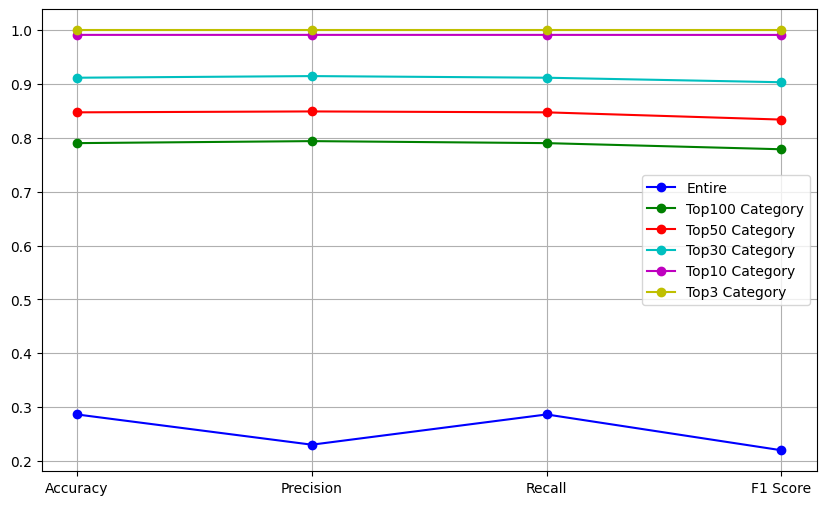

In [117]:
import matplotlib.pyplot as plt

categories = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [
    [accuracy_entire, precision_entire, recall_entire, f1_entire],
    [accuracy_top100_category, precision_top100_category, recall_top100_category, f1_top100_category],
    [accuracy_top50_category, precision_top50_category, recall_top50_category, f1_top50_category],
    [accuracy_top30_category, precision_top30_category, recall_top30_category, f1_top30_category],
    [accuracy_top10_category, precision_top10_category, recall_top10_category, f1_top10_category],
    [accuracy_top3_category, precision_top3_category, recall_top3_category, f1_top3_category]
]

colors = ['b', 'g', 'r', 'c', 'm', 'y']

plt.figure(figsize=(10, 6))

for i, (label, data) in enumerate(zip(["Entire",  "Top100 Category", "Top50 Category", "Top30 Category",  "Top10 Category", "Top3 Category"], values)):
    plt.plot(categories, data, marker='o', label=label, color=colors[i])

plt.legend()
plt.grid(True)  
plt.show()

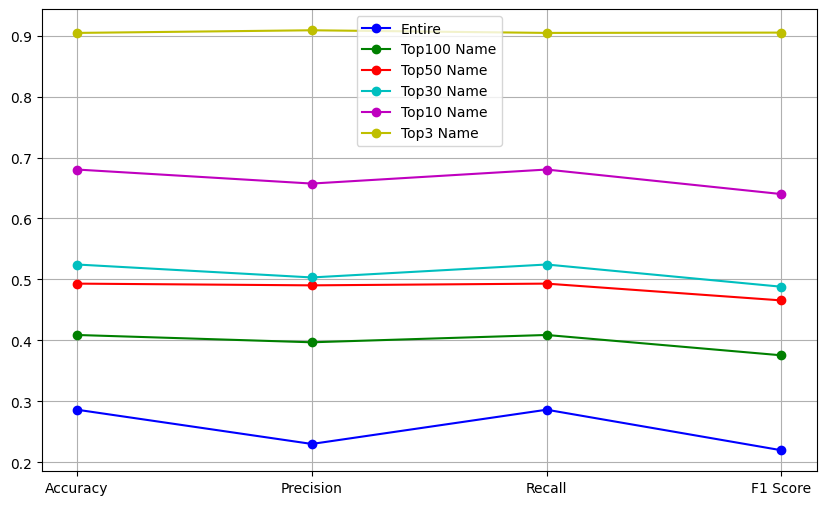

In [118]:
import matplotlib.pyplot as plt

categories = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [
    [accuracy_entire, precision_entire, recall_entire, f1_entire],
    [accuracy_top100_name, precision_top100_name, recall_top100_name, f1_top100_name],
    [accuracy_top50_name, precision_top50_name, recall_top50_name, f1_top50_name],
    [accuracy_top30_name, precision_top30_name, recall_top30_name, f1_top30_name],
    [accuracy_top10_name, precision_top10_name, recall_top10_name, f1_top10_name],
    [accuracy_top3_name, precision_top3_name, recall_top3_name, f1_top3_name]
]

colors = ['b', 'g', 'r', 'c', 'm', 'y']

plt.figure(figsize=(10, 6))

for i, (label, data) in enumerate(zip(["Entire", "Top100 Name",  "Top50 Name", "Top30 Name",  "Top10 Name", "Top3 Name"], values)):
    plt.plot(categories, data, marker='o', label=label, color=colors[i])

plt.legend()
plt.grid(True)  
plt.show()